In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the decay of a 2-level atom into the cavity. I work in the subspace:
$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [3]:
def get_data_decay(L, T, dt, omega_A, omega_max, g_0, x_A, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)

    n_A = 1  #number of atoms
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #tab of couplings
    g_tab = np.zeros((n_modes, n_A), dtype=complex)
    for i in range(n_modes):
        for j in range(n_A):
            if use_WW_approx:
                g_tab[i, j] = g_0*np.sqrt(omega_A / L)*np.exp(-1j*x_A*k_tab[i])*1j
            else:
                g_tab[i, j] = g_0*np.sqrt(omega_tab[i] / L)*np.exp(-1j*x_A*k_tab[i])*1j #in my case, g is independant of the atom index

    #Creation of the Hamiltonian
    dim_subspace = n_modes + n_A
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    for i in range(n_A):
        H_matrix[n_modes+i, n_modes+i] = omega_A

    ##off diagonal elements
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[n_modes+j, i] = g_tab[i, j]
            H_matrix[i,n_modes+j] = np.conjugate(H_matrix[n_modes+j,i])

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    ##Initial state : the atom is excited 
    init_state = qt.basis(dim_subspace, n_modes) 

    #time evolution
    nb_pts = int(T/dt)
    times = np.linspace(0, T, nb_pts)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states
    
    N_A_tab = np.zeros(nb_pts)
    for t in range(nb_pts):
        N_A_tab[t] = np.abs(init_state.dag() * state_list[t])**2
        

    return times, N_A_tab

First test of the function

In [4]:
L = 250*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A
x_A = 0

#numerical implementation of momentum space
omega_max = 10

times, N_A_tab = get_data_decay(L, T, dt, omega_A, omega_max, g_0, x_A, use_WW_approx=True, print_nb_modes=True)

Number of modes:  2501
10.0%. Run time:   3.72s. Est. time left: 00:00:00:33
20.0%. Run time:   7.93s. Est. time left: 00:00:00:31
30.0%. Run time:  12.10s. Est. time left: 00:00:00:28
40.0%. Run time:  15.69s. Est. time left: 00:00:00:23
50.0%. Run time:  19.36s. Est. time left: 00:00:00:19
60.0%. Run time:  23.06s. Est. time left: 00:00:00:15
70.0%. Run time:  26.92s. Est. time left: 00:00:00:11
80.0%. Run time:  30.90s. Est. time left: 00:00:00:07
90.0%. Run time:  34.45s. Est. time left: 00:00:00:03
100.0%. Run time:  38.29s. Est. time left: 00:00:00:00
Total run time:  38.29s


<h2> Inspect occupation number of the atom </h2>

In [9]:
#theoretical prediction
gamma = 2* g_0**2 *omega_A 
tau = 1/gamma
test_curve = np.exp(-gamma*times)

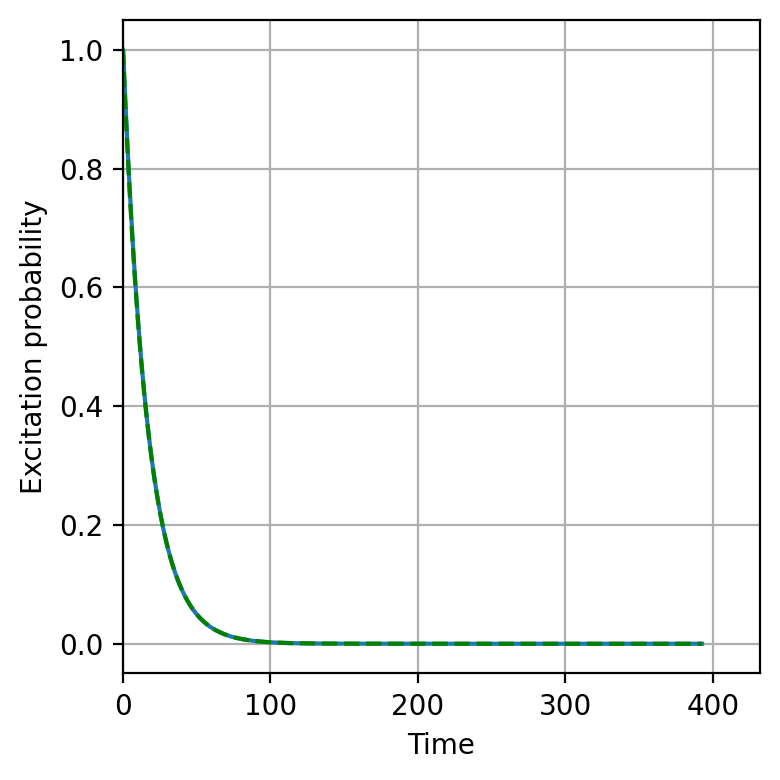

In [10]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)

ax.plot(times, N_A_tab)
#some test
ax.plot(times, test_curve, linestyle='--', color='green', label=r"$\exp(-\gamma t)$")
ax.set_xlim(0, 1.1*times[-1])
ax.set_xlabel('Time')
ax.set_ylabel('Excitation probability')
ax.grid()

fig.tight_layout()
plt.show()